### Loading data

In [1]:
# Loading necessary modules
import pandas as pd
from wordcloud import STOPWORDS, WordCloud
from gensim.models import CoherenceModel
from gensim import corpora
from pprint import pprint
import string
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

/home/doit/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to /home/doit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Read csv in to data
tweet_data = pd.read_csv('../processed_tweet_data.csv')

In [3]:
# print top 5 rows
tweet_data.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Fri Jun 18 17:55:49 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...","🚨Africa is ""in the midst of a full-blown third...",0.166667,0.188889,en,548,612,ketuesriche,551,351,NaN,[],"[{'screen_name': 'TelGlobalHealth', 'name': 'T...",Mass
1,Fri Jun 18 17:55:59 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Dr Moeti is head of WHO in Africa, and one of ...",0.133333,0.455556,en,195,92,Grid1949,66,92,NaN,[],"[{'screen_name': 'globalhlthtwit', 'name': 'An...","Edinburgh, Scotland"
2,Fri Jun 18 17:56:07 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",Thank you @research2note for creating this ama...,0.316667,0.483333,en,2,1,LeeTomlinson8,1195,1176,NaN,"[{'text': 'red4research', 'indices': [103, 116]}]","[{'screen_name': 'NHSRDForum', 'name': 'NHS R&...",NaN
3,Fri Jun 18 17:56:10 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Former Pfizer VP and Virologist, Dr. Michael Y...",0.086111,0.197222,en,1580,899,RIPNY08,2666,2704,NaN,[],"[{'screen_name': 'HighWireTalk', 'name': 'The ...",NaN
4,Fri Jun 18 17:56:20 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",I think it’s important that we don’t sell COVA...,0.280000,0.620000,en,72,20,pash22,28250,30819,NaN,[],"[{'screen_name': 'PeterHotez', 'name': 'Prof P...",United Kingdom


### Data cleaning

* Since the goal of this analysis is to perform topic modeling, let's focus only on the text data and polarity.

In [4]:
# select only 'original_text' and 'polarity' columns
tweet_data = tweet_data[['original_text', 'polarity']]
tweet_data.head()

,original_text,polarity
0,"🚨Africa is ""in the midst of a full-blown third...",0.166667
1,"Dr Moeti is head of WHO in Africa, and one of ...",0.133333
2,Thank you @research2note for creating this ama...,0.316667
3,"Former Pfizer VP and Virologist, Dr. Michael Y...",0.086111
4,I think it’s important that we don’t sell COVA...,0.280000


In [5]:
# text Preprocessing
tweet_data['original_text']=tweet_data['original_text'].astype(str)

# Convert to lowercase
tweet_data['original_text'] = tweet_data['original_text'].map(lambda x: x.lower())

# Remove punctuation
tweet_data['original_text']= \
tweet_data['original_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))

In [6]:
tweet_data.head()

,original_text,polarity
0,🚨africa is in the midst of a fullblown third w...,0.166667
1,dr moeti is head of who in africa and one of t...,0.133333
2,thank you research2note for creating this amaz...,0.316667
3,former pfizer vp and virologist dr michael yea...,0.086111
4,i think it’s important that we don’t sell cova...,0.280000


### Exploratory analysis
* To verify whether the preprocessing, we’ll make a simple word cloud using the `wordcloud` package to get a visual representation of most common words.

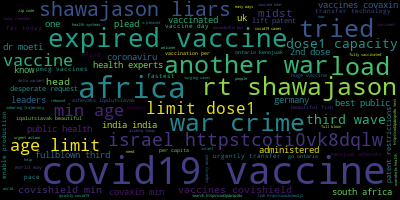

In [7]:
# Join the different processed titles together.
long_string = ','.join(list(tweet_data['original_text'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="black", max_words=800, contour_width=8, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### Preparing data for LDA analysis
* Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [8]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = tweet_data.original_text.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['africa', 'midst', 'fullblown', 'third', 'wave', 'coronavirus', 'head', 'whoafro', 'warned', 'cases', 'risen', 'across', 'continent', 'deaths', 'also', 'risen', 'last', 'week', 'jriggers', 'reports']


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]


### LDA model training
* To keep things simple, we'll keep all the parameters to default except for inputting the number of topics. For this tutorial, we will build a model with 10 topics where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic.

In [10]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.033*"covid" + 0.018*"vaccines" + 0.015*"india" + 0.011*"africa" + '
  '0.010*"httpstco" + 0.010*"vaccine" + 0.009*"amp" + 0.009*"people" + '
  '0.008*"bringing" + 0.008*"total"'),
 (1,
  '0.040*"covid" + 0.026*"need" + 0.024*"vaccines" + 0.018*"world" + '
  '0.018*"oxygen" + 0.012*"health" + 0.010*"dying" + 0.010*"patients" + '
  '0.009*"workers" + 0.009*"mulago"'),
 (2,
  '0.055*"vaccines" + 0.031*"rt" + 0.030*"israel" + 0.030*"expired" + '
  '0.030*"another" + 0.030*"liars" + 0.030*"war" + 0.030*"load" + '
  '0.030*"tried" + 0.030*"crime"'),
 (3,
  '0.043*"covid" + 0.036*"vaccines" + 0.011*"vaccinated" + 0.009*"million" + '
  '0.009*"people" + 0.009*"fully" + 0.008*"africa" + 0.008*"doses" + '
  '0.007*"could" + 0.007*"vaccine"'),
 (4,
  '0.030*"vaccines" + 0.023*"covid" + 0.020*"dose" + 0.012*"age" + 0.011*"min" '
  '+ 0.011*"pin" + 0.011*"capacity" + 0.011*"code" + 0.011*"limit" + '
  '0.011*"hospital"'),
 (5,
  '0.033*"covid" + 0.028*"vaccines" + 0.015*"africa" + 0.012*"

### Analyzing LDA model results
* Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

In [11]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
doc_lda = lda_model[corpus]


# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)


Perplexity:  -6.717813488983866

 Ldamodel Coherence Score/Accuracy on Tweets:  0.40642575186356195


#### Anlayizing results Exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics

In [12]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.229376  0.044759       1        1  14.908987
6      0.054163 -0.094882       2        1  13.955796
9     -0.131380  0.108265       3        1  10.867367
3      0.011492  0.017278       4        1  10.415690
0     -0.080873  0.017002       5        1  10.255913
8     -0.023018 -0.168611       6        1   9.753902
7     -0.024855  0.072849       7        1   9.629658
5      0.014223  0.086780       8        1   8.269482
1     -0.123690 -0.066530       9        1   7.253884
4      0.074562 -0.016911      10        1   4.689320, topic_info=            Term        Freq        Total Category  logprob  loglift
1490  httpstcoti  615.000000   615.000000  Default  30.0000  30.0000
1489        dqlw  613.000000   613.000000  Default  29.0000  29.0000
1494          vk  614.000000   614.000000  Default  28.0000  28.0000
1491       liars  728.000000   728.000000  Default  27.0000  27.0000
1492        load  726.000000   726.000000  Default  26.0000  26.0000
...          ...         ...          ...      ...      ...      ...
212     httpstco   25.683348   682.625214  Topic10  -5.4010  -0.2202
1         africa   27.688041  1503.187342  Topic10  -5.3258  -0.9345
352        world   21.096452   754.961986  Topic10  -5.5977  -0.5177
215           rt   20.053840  1038.258111  Topic10  -5.6484  -0.8870
232        india   19.797559   730.118418  Topic10  -5.6612  -0.5478

[787 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
171       5  0.727614       abdala
171       7  0.099220       abdala
171      10  0.132294       abdala
1746      1  0.845180  accelerates
1746      3  0.084518  accelerates
...     ...       ...          ...
125       6  0.021576          zip
125       7  0.316455          zip
125       8  0.021576          zip
125       9  0.007192          zip
3319      7  0.865476         zntk

[2838 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 10, 4, 1, 9, 8, 6, 2, 5])

### Reference

* [Towards Data Science](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)
* [Modeling_Twitter](https://colab.research.google.com/drive/1K9g6B0iHVXScACh9XIAKwmDRyTRMDbMJ#scrollTo=eylzfskkr8f7)